# Predição do Valor do Ouro
## Time Series Cross-Validation com AdaBoost Regressor

**Objetivo:** Prever o preço do ouro usando séries temporais com validação cruzada específica para dados temporais (TimeSeriesSplit) com gap de 48 horas.

**Metodologia:**
- Validação: TimeSeriesSplit com 5-CV e gap de 48 horas
- Modelo: AdaBoost Regressor
- Fonte de dados: Arquivo CSV "Dados Históricos - Ouro Futuros.csv"
- Ativo: GC=F (Gold Futures)
- Período: 01/01/2025 a 31/10/2025

In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
import requests
import urllib3

# Ignorar avisos futuros para um output mais limpo
warnings.simplefilter(action='ignore', category=FutureWarning)

In [67]:
# Configurações do Ticker
ticker = 'GC=F'
csv_file = 'Dados Históricos - Ouro Futuros.csv'

print("=" * 70)
print("CARREGAMENTO DE DADOS - Preço do Ouro")
print("=" * 70)
print(f"Ticker: {ticker}")
print(f"Fonte: {csv_file}")
print("=" * 70)

# Carregar dados do arquivo CSV
try:
    # Tentar diferentes formatos de data e delimitadores
    data = pd.read_csv(csv_file, parse_dates=['Data'], dayfirst=True)
    
    # Se a coluna não for 'Data', tentar 'Date'
    if 'Data' not in data.columns and 'Date' in data.columns:
        data.rename(columns={'Date': 'Data'}, inplace=True)
    
    # Definir Data como índice
    data.set_index('Data', inplace=True)
    
    # Ordenar por data (do mais antigo para o mais recente)
    data.sort_index(inplace=True)
    
    # Padronizar nomes das colunas para inglês (compatível com yfinance)
    column_mapping = {
        'Último': 'Close',
        'Abertura': 'Open', 
        'Máxima': 'High',
        'Mínima': 'Low',
        'Vol.': 'Volume',
        'Var%': 'Change%'
    }
    
    # Renomear apenas as colunas que existem
    data.rename(columns={k: v for k, v in column_mapping.items() if k in data.columns}, inplace=True)
    
    # Limpar e converter colunas numéricas (preços)
    numeric_columns = ['Open', 'High', 'Low', 'Close']
    for col in numeric_columns:
        if col in data.columns:
            # Remover pontos de milhar e converter vírgula decimal para ponto
            data[col] = data[col].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
            data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Limpar dados de volume (remover K, M, B e converter para número)
    if 'Volume' in data.columns:
        def parse_volume(vol):
            if pd.isna(vol) or vol == '-':
                return 0
            vol = str(vol).replace(',', '.')
            if 'K' in vol:
                return float(vol.replace('K', '')) * 1000
            elif 'M' in vol:
                return float(vol.replace('M', '')) * 1000000
            elif 'B' in vol:
                return float(vol.replace('B', '')) * 1000000000
            else:
                return float(vol)
        
        data['Volume'] = data['Volume'].apply(parse_volume).astype(int)
    
    # Limpar percentuais (remover % e converter)
    if 'Change%' in data.columns:
        data['Change%'] = data['Change%'].str.replace('%', '').str.replace(',', '.').astype(float)
    
    # Criar estrutura multi-level compatível com yfinance
    data.columns = pd.MultiIndex.from_product([[ticker], data.columns])
    
    print(f"\n✓ Dados carregados com sucesso do arquivo CSV!")
    print(f"\nEstatísticas dos dados:")
    print(f"  • Total de registros: {data.shape[0]:,}")
    print(f"  • Período: {data.index[0].strftime('%d/%m/%Y')} até {data.index[-1].strftime('%d/%m/%Y')}")
    
    if (ticker, 'Close') in data.columns:
        print(f"  • Preço médio: ${data[(ticker, 'Close')].mean():.2f}")
        print(f"  • Preço mínimo: ${data[(ticker, 'Close')].min():.2f}")
        print(f"  • Preço máximo: ${data[(ticker, 'Close')].max():.2f}")
        print(f"  • Volatilidade (std): ${data[(ticker, 'Close')].std():.2f}")
    
    print(f"\nColunas disponíveis: {[col[1] for col in data.columns]}")
    print("\nVisualização dos dados:")
    print(data.head())
    print("=" * 70)
    
except FileNotFoundError:
    print(f"\n❌ ERRO: Arquivo '{csv_file}' não encontrado!")
    print("\nVerifique se o arquivo está no mesmo diretório do notebook.")
    print("Nome esperado: 'Dados Históricos - Ouro Futuros.csv'")
    print("=" * 70)
    raise
    
except Exception as e:
    print(f"\n❌ ERRO ao carregar o arquivo: {str(e)}")
    print("\nTentando exibir estrutura do arquivo para diagnóstico...")
    try:
        sample_data = pd.read_csv(csv_file, nrows=5)
        print("\nPrimeiras linhas do arquivo:")
        print(sample_data)
        print(f"\nColunas encontradas: {sample_data.columns.tolist()}")
    except:
        pass
    print("=" * 70)
    raise

CARREGAMENTO DE DADOS - Preço do Ouro
Ticker: GC=F
Fonte: Dados Históricos - Ouro Futuros.csv

✓ Dados carregados com sucesso do arquivo CSV!

Estatísticas dos dados:
  • Total de registros: 216
  • Período: 02/01/2025 até 31/10/2025
  • Preço médio: $3325.78
  • Preço mínimo: $2647.40
  • Preço máximo: $4359.40
  • Volatilidade (std): $375.41

Colunas disponíveis: ['Close', 'Open', 'High', 'Low', 'Volume', 'Change%']

Visualização dos dados:
              GC=F                                        
             Close    Open    High     Low  Volume Change%
Data                                                      
2025-01-02  2669.0  2641.0  2674.2  2636.1  144520    1.06
2025-01-03  2654.7  2671.1  2681.0  2649.7  121170   -0.54
2025-01-06  2647.4  2652.8  2663.8  2624.6  169920   -0.27
2025-01-07  2665.4  2647.1  2678.5  2643.5  161620    0.68
2025-01-08  2672.4  2662.9  2687.0  2658.4  197370    0.26


## 3. Análise Exploratória dos Dados

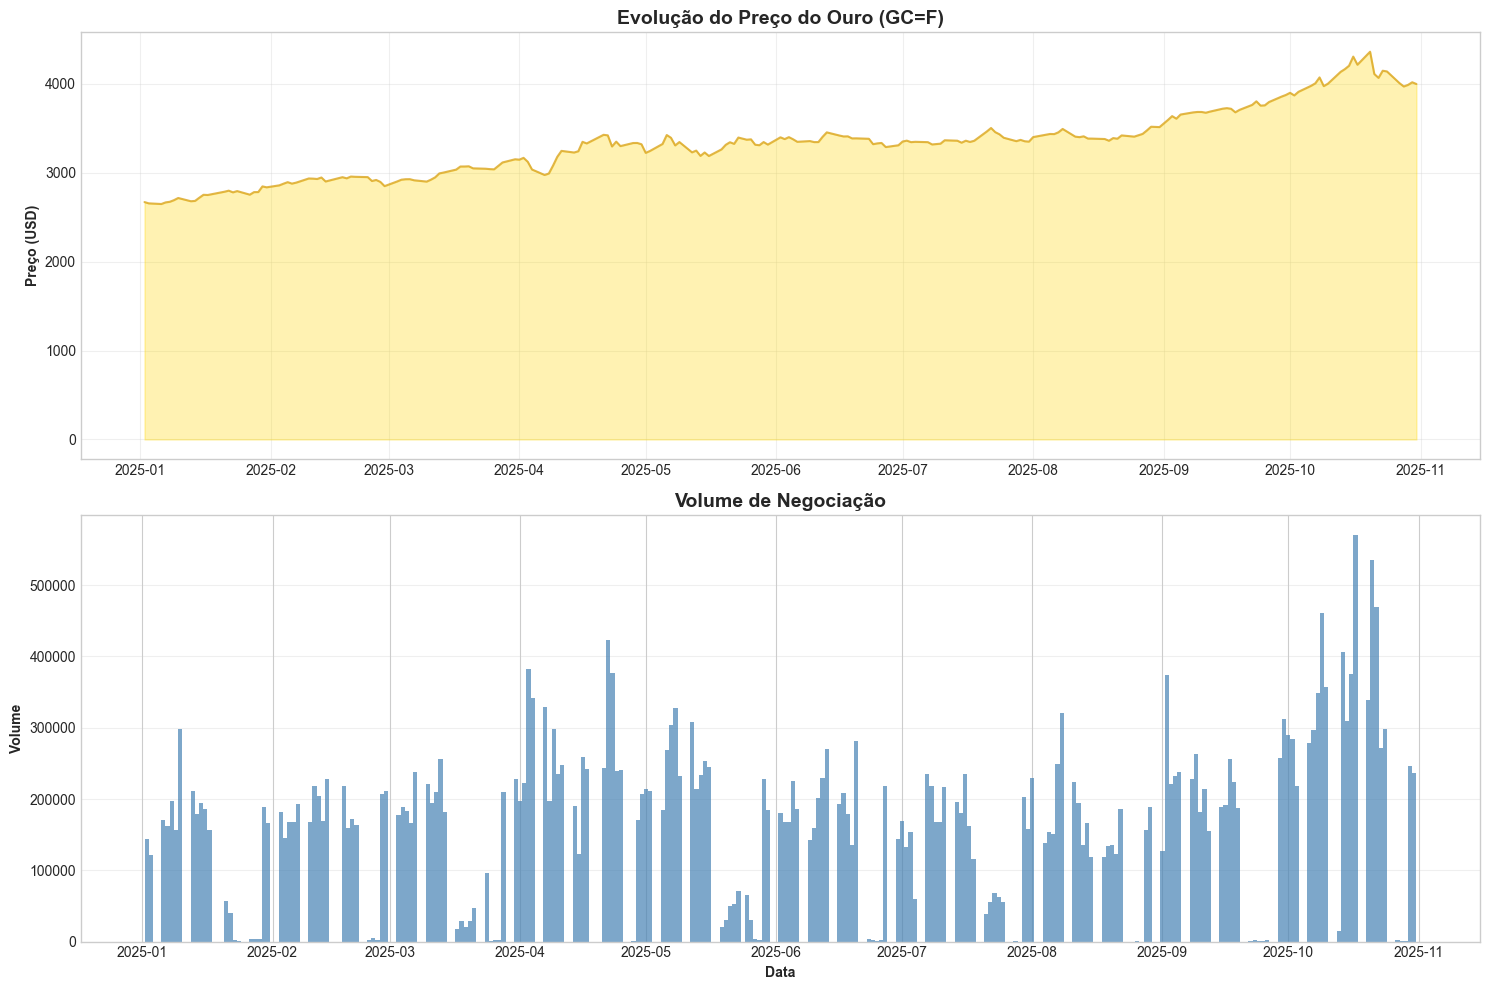


ESTATÍSTICAS DESCRITIVAS

Preço de Fechamento:
  • Média: $3325.78
  • Mediana: $3343.95
  • Desvio Padrão: $375.41
  • Mínimo: $2647.40
  • Máximo: $4359.40
  • Amplitude: $1712.00


In [68]:
# Visualização da série temporal do preço do ouro
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Preço de Fechamento
axes[0].plot(data.index, data[(ticker, 'Close')], color='goldenrod', linewidth=1.5, alpha=0.8)
axes[0].set_title('Evolução do Preço do Ouro (GC=F)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Preço (USD)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(data.index, data[(ticker, 'Close')], alpha=0.3, color='gold')

# Gráfico 2: Volume de Negociação
if (ticker, 'Volume') in data.columns:
    axes[1].bar(data.index, data[(ticker, 'Volume')], color='steelblue', alpha=0.7, width=1)
    axes[1].set_title('Volume de Negociação', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('Volume', fontweight='bold')
    axes[1].set_xlabel('Data', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("\n" + "=" * 70)
print("ESTATÍSTICAS DESCRITIVAS")
print("=" * 70)
print(f"\nPreço de Fechamento:")
print(f"  • Média: ${data[(ticker, 'Close')].mean():.2f}")
print(f"  • Mediana: ${data[(ticker, 'Close')].median():.2f}")
print(f"  • Desvio Padrão: ${data[(ticker, 'Close')].std():.2f}")
print(f"  • Mínimo: ${data[(ticker, 'Close')].min():.2f}")
print(f"  • Máximo: ${data[(ticker, 'Close')].max():.2f}")
print(f"  • Amplitude: ${data[(ticker, 'Close')].max() - data[(ticker, 'Close')].min():.2f}")
print("=" * 70)

## 4. Engenharia de Features para Séries Temporais

In [69]:
# Criar DataFrame de trabalho simplificado
df = pd.DataFrame({
    'Close': data[(ticker, 'Close')],
    'Open': data[(ticker, 'Open')],
    'High': data[(ticker, 'High')],
    'Low': data[(ticker, 'Low')]
})

if (ticker, 'Volume') in data.columns:
    df['Volume'] = data[(ticker, 'Volume')]

print("Criando features para séries temporais...")
print("=" * 70)

# 1. Features de Lag (valores passados - até 48h)
lag_periods = [1, 2, 3, 5, 7, 10, 14, 21]
for lag in lag_periods:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    if 'Volume' in df.columns:
        df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)

print(f"✓ Features de lag criadas: {len(lag_periods)} períodos")

# 2. Features de Rolling Window (médias móveis)
windows = [3, 5, 7, 10, 14, 21, 30]
for window in windows:
    df[f'Close_MA_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'Close_Std_{window}'] = df['Close'].rolling(window=window).std()
    df[f'Close_Min_{window}'] = df['Close'].rolling(window=window).min()
    df[f'Close_Max_{window}'] = df['Close'].rolling(window=window).max()

print(f"✓ Features de rolling window criadas: {len(windows)} janelas")

# 3. Features de variação percentual e momentum
df['Daily_Return'] = df['Close'].pct_change()
df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low']
df['Close_Open_Pct'] = (df['Close'] - df['Open']) / df['Open']

# Momentum de diferentes períodos
for period in [3, 5, 7, 14]:
    df[f'Momentum_{period}'] = df['Close'] - df['Close'].shift(period)

print(f"✓ Features de momentum e variação criadas")

# 4. Features de volatilidade
for window in [5, 10, 20]:
    df[f'Volatility_{window}'] = df['Daily_Return'].rolling(window=window).std()

print(f"✓ Features de volatilidade criadas")

# 5. RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'], 14)
df['RSI_7'] = calculate_rsi(df['Close'], 7)

print(f"✓ Indicadores técnicos (RSI) criados")

# 6. Features temporais
df['Day_of_Week'] = df.index.dayofweek
df['Day_of_Month'] = df.index.day
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

print(f"✓ Features temporais criadas")

print(f"\n✓ Total de features criadas: {df.shape[1]}")
print(f"Shape do dataset: {df.shape}")
print("=" * 70)

Criando features para séries temporais...
✓ Features de lag criadas: 8 períodos
✓ Features de rolling window criadas: 7 janelas
✓ Features de momentum e variação criadas
✓ Features de volatilidade criadas
✓ Indicadores técnicos (RSI) criados
✓ Features temporais criadas

✓ Total de features criadas: 65
Shape do dataset: (216, 65)


## 5. Preparação dos Dados para Modelagem

In [70]:
# Remover valores ausentes gerados pelos lags e rolling windows
df_clean = df.dropna()

print("=" * 70)
print("PREPARAÇÃO DOS DADOS")
print("=" * 70)
print(f"Registros antes da limpeza: {len(df):,}")
print(f"Registros após limpeza: {len(df_clean):,}")
print(f"Registros removidos: {len(df) - len(df_clean):,}")

# Criar target: prever o preço do próximo período
df_clean['Target'] = df_clean['Close'].shift(-1)
df_clean = df_clean.dropna()

# Separar features e target
exclude_columns = ['Target', 'Close', 'Open', 'High', 'Low']
if 'Volume' in df_clean.columns:
    exclude_columns.append('Volume')

feature_columns = [col for col in df_clean.columns if col not in exclude_columns]
X = df_clean[feature_columns]
y = df_clean['Target']

print(f"\nShape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nPeríodo dos dados:")
print(f"  Início: {df_clean.index.min().strftime('%d/%m/%Y')}")
print(f"  Fim: {df_clean.index.max().strftime('%d/%m/%Y')}")
print(f"\nFeatures utilizadas ({len(feature_columns)}):")
for i, col in enumerate(feature_columns[:15], 1):
    print(f"  {i:2d}. {col}")
if len(feature_columns) > 15:
    print(f"  ... e mais {len(feature_columns) - 15} features")
print("=" * 70)

PREPARAÇÃO DOS DADOS
Registros antes da limpeza: 216
Registros após limpeza: 187
Registros removidos: 29

Shape de X (features): (186, 60)
Shape de y (target): (186,)

Período dos dados:
  Início: 13/02/2025
  Fim: 30/10/2025

Features utilizadas (60):
   1. Close_Lag_1
   2. Volume_Lag_1
   3. Close_Lag_2
   4. Volume_Lag_2
   5. Close_Lag_3
   6. Volume_Lag_3
   7. Close_Lag_5
   8. Volume_Lag_5
   9. Close_Lag_7
  10. Volume_Lag_7
  11. Close_Lag_10
  12. Volume_Lag_10
  13. Close_Lag_14
  14. Volume_Lag_14
  15. Close_Lag_21
  ... e mais 45 features


## 6. Configuração do TimeSeriesSplit com Gap de 48h

CONFIGURAÇÃO DO TIME SERIES CROSS-VALIDATION
Número de splits: 5
Gap entre treino e teste: 2 dias (~48 horas)
Total de amostras: 186

Distribuição dos Splits:
----------------------------------------------------------------------

Fold 1:
  Treino:   29 amostras | 13/02/2025 até 26/03/2025
  Teste:    31 amostras | 31/03/2025 até 13/05/2025

Fold 2:
  Treino:   60 amostras | 13/02/2025 até 09/05/2025
  Teste:    31 amostras | 14/05/2025 até 24/06/2025

Fold 3:
  Treino:   91 amostras | 13/02/2025 até 20/06/2025
  Teste:    31 amostras | 25/06/2025 até 06/08/2025

Fold 4:
  Treino:  122 amostras | 13/02/2025 até 04/08/2025
  Teste:    31 amostras | 07/08/2025 até 17/09/2025

Fold 5:
  Treino:  153 amostras | 13/02/2025 até 15/09/2025
  Teste:    31 amostras | 18/09/2025 até 30/10/2025



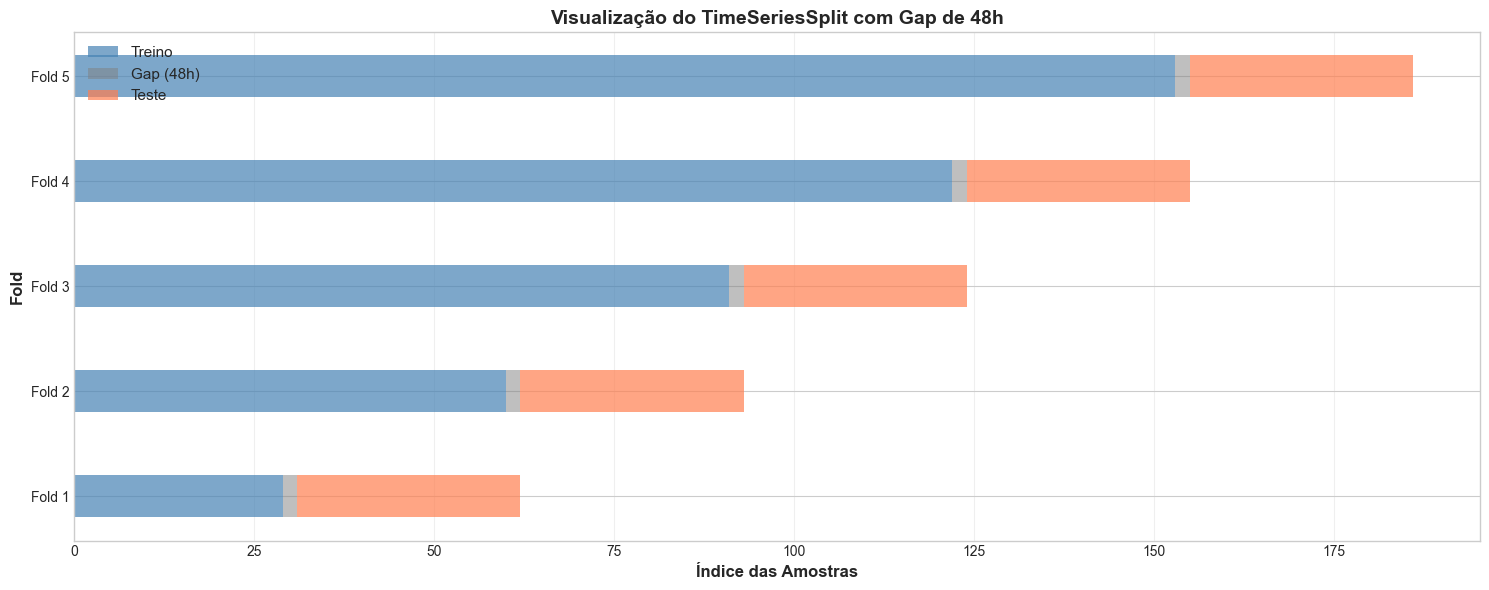

In [71]:
from sklearn.preprocessing import StandardScaler

# TimeSeriesSplit com 5 folds e gap de 48 horas (2 dias úteis)
n_splits = 5
gap = 2  # 2 dias = aproximadamente 48 horas em dias úteis

tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

print("=" * 70)
print("CONFIGURAÇÃO DO TIME SERIES CROSS-VALIDATION")
print("=" * 70)
print(f"Número de splits: {n_splits}")
print(f"Gap entre treino e teste: {gap} dias (~48 horas)")
print(f"Total de amostras: {len(X):,}")
print("=" * 70)

# Visualizar os splits
print("\nDistribuição dos Splits:")
print("-" * 70)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    train_dates = df_clean.iloc[train_idx].index
    test_dates = df_clean.iloc[test_idx].index
    
    print(f"\nFold {fold}:")
    print(f"  Treino: {len(train_idx):4d} amostras | {train_dates.min().strftime('%d/%m/%Y')} até {train_dates.max().strftime('%d/%m/%Y')}")
    print(f"  Teste:  {len(test_idx):4d} amostras | {test_dates.min().strftime('%d/%m/%Y')} até {test_dates.max().strftime('%d/%m/%Y')}")

print("\n" + "=" * 70)

# Visualização gráfica dos splits
fig, ax = plt.subplots(figsize=(15, 6))

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    # Treino
    ax.barh(fold, len(train_idx), left=train_idx[0], 
            height=0.4, color='steelblue', alpha=0.7, label='Treino' if fold == 1 else '')
    
    # Gap
    gap_start = train_idx[-1] + 1
    gap_end = test_idx[0] - 1
    if gap_end >= gap_start:
        ax.barh(fold, gap_end - gap_start + 1, left=gap_start, 
                height=0.4, color='gray', alpha=0.5, label='Gap (48h)' if fold == 1 else '')
    
    # Teste
    ax.barh(fold, len(test_idx), left=test_idx[0], 
            height=0.4, color='coral', alpha=0.7, label='Teste' if fold == 1 else '')

ax.set_xlabel('Índice das Amostras', fontweight='bold', fontsize=12)
ax.set_ylabel('Fold', fontweight='bold', fontsize=12)
ax.set_title('Visualização do TimeSeriesSplit com Gap de 48h', fontweight='bold', fontsize=14)
ax.set_yticks(range(1, n_splits + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(1, n_splits + 1)])
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Treinamento com AdaBoost Regressor

In [74]:
from sklearn.tree import DecisionTreeRegressor

# Configurar AdaBoost Regressor
base_estimator = DecisionTreeRegressor(max_depth=4, random_state=42)
adaboost = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

print("=" * 70)
print("CONFIGURAÇÃO DO ADABOOST REGRESSOR")
print("=" * 70)
print(f"Estimador base: DecisionTreeRegressor(max_depth=4)")
print(f"Número de estimadores: 100")
print(f"Learning rate: 0.1")
print(f"Random state: 42")
print("=" * 70)

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✓ Dados normalizados com StandardScaler")
print(f"Shape de X normalizado: {X_scaled.shape}")
print("=" * 70)

CONFIGURAÇÃO DO ADABOOST REGRESSOR
Estimador base: DecisionTreeRegressor(max_depth=4)
Número de estimadores: 100
Learning rate: 0.1
Random state: 42

✓ Dados normalizados com StandardScaler
Shape de X normalizado: (186, 60)


## 8. Validação Cruzada com TimeSeriesSplit

In [76]:
from sklearn.model_selection import cross_validate

print("=" * 70)
print("EXECUTANDO VALIDAÇÃO CRUZADA")
print("=" * 70)
print("Treinando com TimeSeriesSplit (5-CV, Gap=48h)...")
print("Aguarde, isso pode levar alguns minutos...\n")

# Definir métricas
scoring = {
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

# Executar validação cruzada
# Usando n_jobs=1 para evitar problemas de serialização em ambiente Windows
cv_results = cross_validate(
    adaboost,
    X_scaled,
    y,
    cv=tscv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=1,  # Execução sequencial para evitar problemas de pickle/serialização
    verbose=0
)

# Calcular métricas
train_rmse = np.sqrt(-cv_results['train_neg_mse'])
test_rmse = np.sqrt(-cv_results['test_neg_mse'])
train_mae = -cv_results['train_neg_mae']
test_mae = -cv_results['test_neg_mae']
train_r2 = cv_results['train_r2']
test_r2 = cv_results['test_r2']

print("✓ Validação cruzada concluída!\n")
print("=" * 70)
print("RESULTADOS - AdaBoost Regressor (TimeSeriesSplit 5-CV, Gap=48h)")
print("=" * 70)

print(f"\nRMSE (Root Mean Squared Error):")
print(f"  Treino: ${train_rmse.mean():.2f} ± ${train_rmse.std():.2f}")
print(f"  Teste:  ${test_rmse.mean():.2f} ± ${test_rmse.std():.2f}")

print(f"\nMAE (Mean Absolute Error):")
print(f"  Treino: ${train_mae.mean():.2f} ± ${train_mae.std():.2f}")
print(f"  Teste:  ${test_mae.mean():.2f} ± ${test_mae.std():.2f}")

print(f"\nR² Score:")
print(f"  Treino: {train_r2.mean():.4f} ± {train_r2.std():.4f}")
print(f"  Teste:  {test_r2.mean():.4f} ± {test_r2.std():.4f}")

print(f"\nTempo de execução:")
print(f"  Tempo médio por fold: {cv_results['fit_time'].mean():.2f}s")
print(f"  Tempo total: {cv_results['fit_time'].sum():.2f}s")

print("\n" + "=" * 70)

EXECUTANDO VALIDAÇÃO CRUZADA
Treinando com TimeSeriesSplit (5-CV, Gap=48h)...
Aguarde, isso pode levar alguns minutos...

✓ Validação cruzada concluída!

RESULTADOS - AdaBoost Regressor (TimeSeriesSplit 5-CV, Gap=48h)

RMSE (Root Mean Squared Error):
  Treino: $12.45 ± $6.83
  Teste:  $189.15 ± $103.86

MAE (Mean Absolute Error):
  Treino: $9.24 ± $5.06
  Teste:  $164.60 ± $92.63

R² Score:
  Treino: 0.9941 ± 0.0040
  Teste:  -2.3447 ± 1.6978

Tempo de execução:
  Tempo médio por fold: 0.24s
  Tempo total: 1.21s

✓ Validação cruzada concluída!

RESULTADOS - AdaBoost Regressor (TimeSeriesSplit 5-CV, Gap=48h)

RMSE (Root Mean Squared Error):
  Treino: $12.45 ± $6.83
  Teste:  $189.15 ± $103.86

MAE (Mean Absolute Error):
  Treino: $9.24 ± $5.06
  Teste:  $164.60 ± $92.63

R² Score:
  Treino: 0.9941 ± 0.0040
  Teste:  -2.3447 ± 1.6978

Tempo de execução:
  Tempo médio por fold: 0.24s
  Tempo total: 1.21s



## 9. Análise Detalhada por Fold

In [78]:
# Criar DataFrame com resultados por fold
fold_results = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'RMSE Treino': train_rmse,
    'RMSE Teste': test_rmse,
    'MAE Treino': train_mae,
    'MAE Teste': test_mae,
    'R² Treino': train_r2,
    'R² Teste': test_r2
})

print("\n" + "=" * 90)
print("MÉTRICAS POR FOLD - TimeSeriesSplit com Gap de 48h")
print("=" * 90)
print(fold_results.to_string(index=False))
print("=" * 90)

print(f"\nAnálise de Desempenho:")
print(f"  RMSE Teste Médio: ${test_rmse.mean():.2f}")
print(f"  MAE Teste Médio: ${test_mae.mean():.2f}")
print(f"  R² Teste Médio: {test_r2.mean():.4f}")
print(f"\n  Melhor Fold (R²): Fold {fold_results['R² Teste'].idxmax() + 1} com R² = {fold_results['R² Teste'].max():.4f}")
print(f"  Pior Fold (R²):   Fold {fold_results['R² Teste'].idxmin() + 1} com R² = {fold_results['R² Teste'].min():.4f}")
print(f"  Variação de R²: {fold_results['R² Teste'].std():.4f}")

print("=" * 90)


MÉTRICAS POR FOLD - TimeSeriesSplit com Gap de 48h
 Fold  RMSE Treino  RMSE Teste  MAE Treino  MAE Teste  R² Treino  R² Teste
    1     1.651594  243.738178    0.957548 219.769355   0.999361 -3.193983
    2     8.582251  126.213396    6.552605 117.039260   0.997463 -4.236224
    3    13.443448   45.955321   10.440932  39.432036   0.994500  0.194404
    4    17.373329  178.275153   12.861801 136.713963   0.990243 -0.893626
    5    21.209280  351.548732   15.363514 310.038410   0.988841 -3.594287

Análise de Desempenho:
  RMSE Teste Médio: $189.15
  MAE Teste Médio: $164.60
  R² Teste Médio: -2.3447

  Melhor Fold (R²): Fold 3 com R² = 0.1944
  Pior Fold (R²):   Fold 2 com R² = -4.2362
  Variação de R²: 1.8982


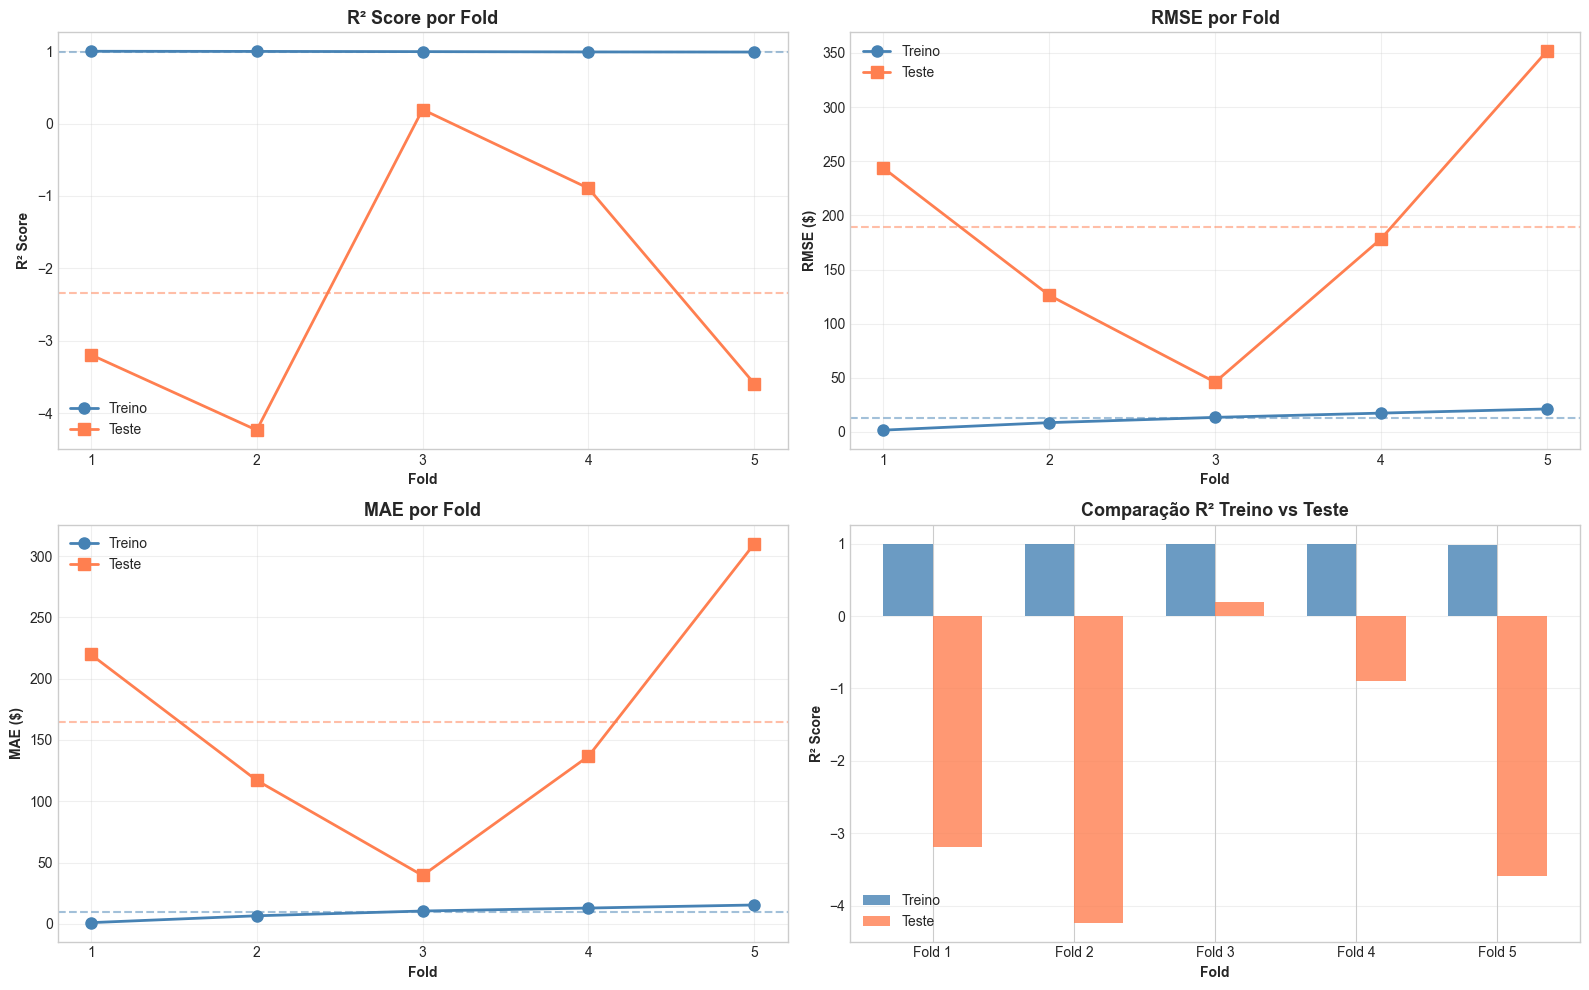

In [79]:
# Visualização dos resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

folds = range(1, n_splits + 1)

# Gráfico 1: R² Score por fold
axes[0, 0].plot(folds, train_r2, marker='o', linewidth=2, markersize=8, 
                label='Treino', color='steelblue')
axes[0, 0].plot(folds, test_r2, marker='s', linewidth=2, markersize=8, 
                label='Teste', color='coral')
axes[0, 0].axhline(y=train_r2.mean(), color='steelblue', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=test_r2.mean(), color='coral', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Fold', fontweight='bold')
axes[0, 0].set_ylabel('R² Score', fontweight='bold')
axes[0, 0].set_title('R² Score por Fold', fontweight='bold', fontsize=13)
axes[0, 0].set_xticks(folds)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: RMSE por fold
axes[0, 1].plot(folds, train_rmse, marker='o', linewidth=2, markersize=8, 
                label='Treino', color='steelblue')
axes[0, 1].plot(folds, test_rmse, marker='s', linewidth=2, markersize=8, 
                label='Teste', color='coral')
axes[0, 1].axhline(y=train_rmse.mean(), color='steelblue', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=test_rmse.mean(), color='coral', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Fold', fontweight='bold')
axes[0, 1].set_ylabel('RMSE ($)', fontweight='bold')
axes[0, 1].set_title('RMSE por Fold', fontweight='bold', fontsize=13)
axes[0, 1].set_xticks(folds)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: MAE por fold
axes[1, 0].plot(folds, train_mae, marker='o', linewidth=2, markersize=8, 
                label='Treino', color='steelblue')
axes[1, 0].plot(folds, test_mae, marker='s', linewidth=2, markersize=8, 
                label='Teste', color='coral')
axes[1, 0].axhline(y=train_mae.mean(), color='steelblue', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=test_mae.mean(), color='coral', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Fold', fontweight='bold')
axes[1, 0].set_ylabel('MAE ($)', fontweight='bold')
axes[1, 0].set_title('MAE por Fold', fontweight='bold', fontsize=13)
axes[1, 0].set_xticks(folds)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Comparação Treino vs Teste (R²)
x_pos = np.arange(n_splits)
width = 0.35
axes[1, 1].bar(x_pos - width/2, train_r2, width, label='Treino', color='steelblue', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, test_r2, width, label='Teste', color='coral', alpha=0.8)
axes[1, 1].set_xlabel('Fold', fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontweight='bold')
axes[1, 1].set_title('Comparação R² Treino vs Teste', fontweight='bold', fontsize=13)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'Fold {i}' for i in range(1, n_splits + 1)])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Modelo Final e Análise de Previsões

In [80]:
# Treinar modelo final com todos os dados
print("=" * 70)
print("TREINAMENTO DO MODELO FINAL")
print("=" * 70)
print("Treinando modelo com todos os dados disponíveis...")

final_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4, random_state=42),
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

final_model.fit(X_scaled, y)
y_pred = final_model.predict(X_scaled)

# Calcular métricas finais
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_mae = mean_absolute_error(y, y_pred)
final_r2 = r2_score(y, y_pred)

print(f"\n✓ Modelo final treinado com sucesso!")
print(f"\nMÉTRICAS DO MODELO FINAL:")
print(f"  RMSE: ${final_rmse:.2f}")
print(f"  MAE:  ${final_mae:.2f}")
print(f"  R²:   {final_r2:.4f}")
print("=" * 70)

TREINAMENTO DO MODELO FINAL
Treinando modelo com todos os dados disponíveis...

✓ Modelo final treinado com sucesso!

MÉTRICAS DO MODELO FINAL:
  RMSE: $27.29
  MAE:  $20.67
  R²:   0.9930

✓ Modelo final treinado com sucesso!

MÉTRICAS DO MODELO FINAL:
  RMSE: $27.29
  MAE:  $20.67
  R²:   0.9930


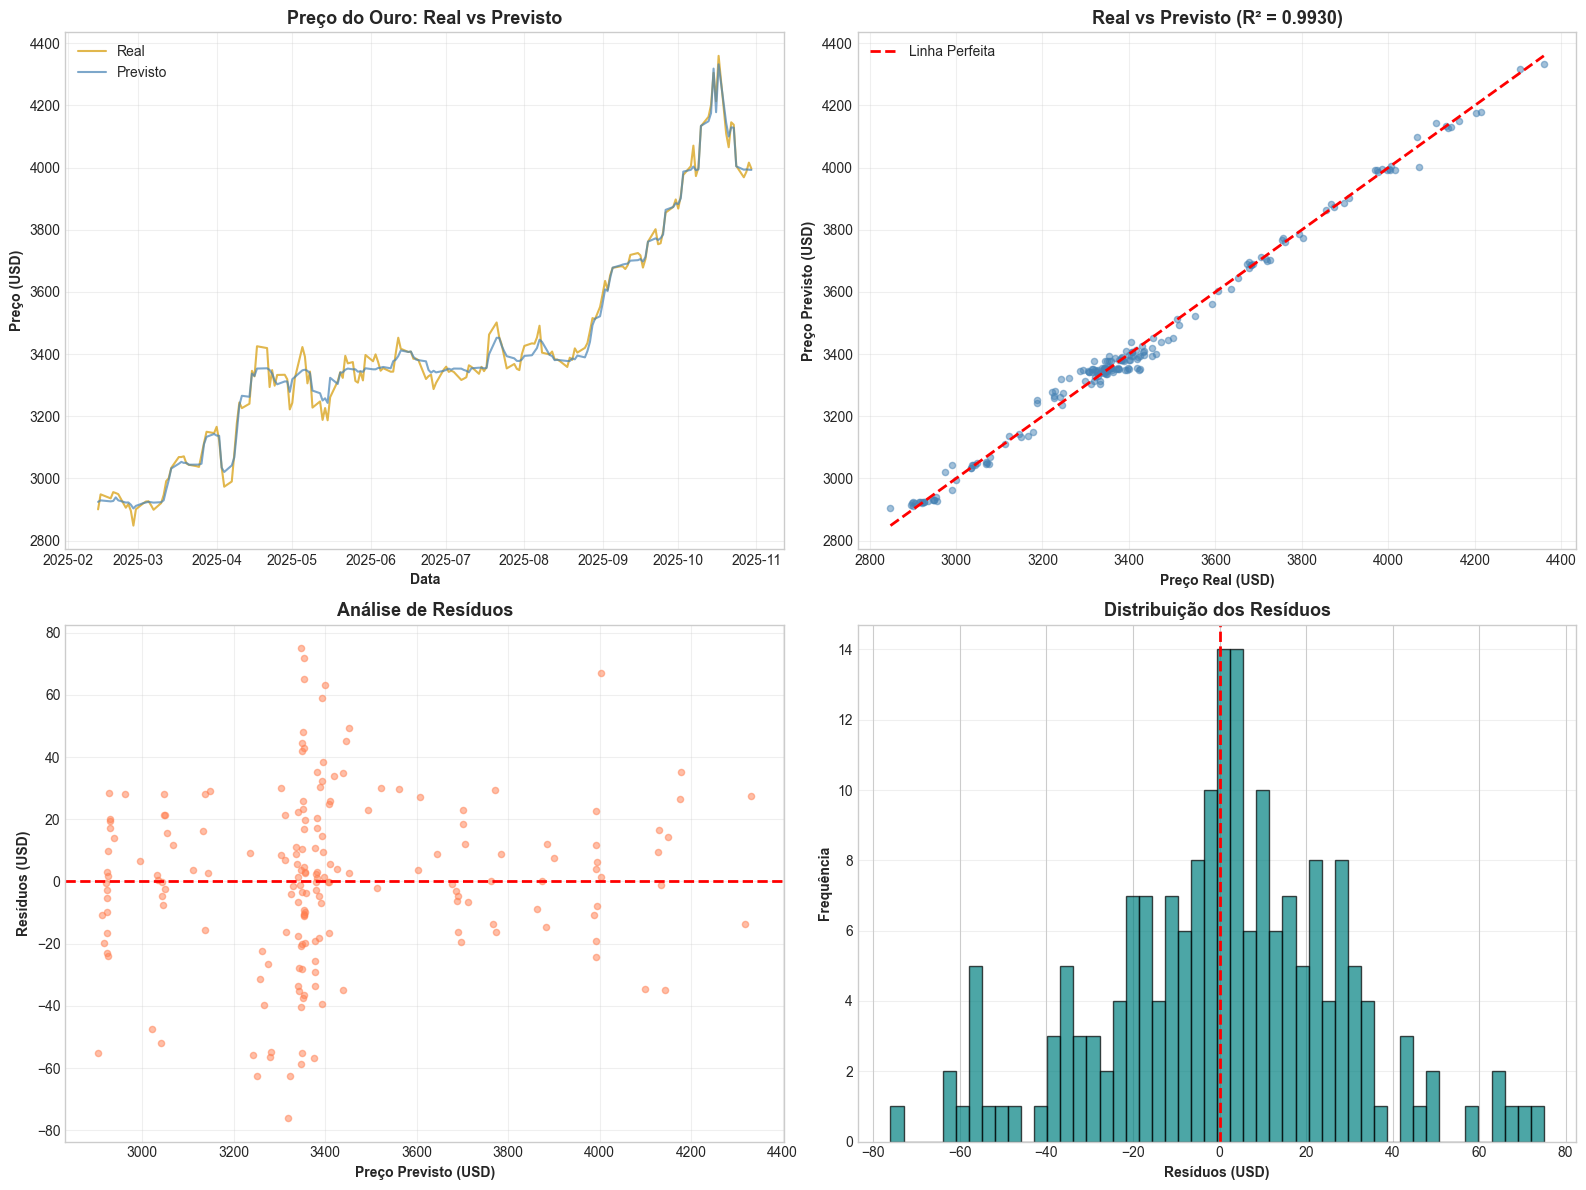


ANÁLISE DE RESÍDUOS
Média dos resíduos: $0.79 (ideal: próximo de 0)
Desvio padrão: $27.35
Mediana: $1.55
Mínimo: $-76.05
Máximo: $74.95


In [81]:
# Visualização das previsões
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Série temporal completa (Real vs Previsto)
axes[0, 0].plot(df_clean.index, y, label='Real', color='goldenrod', linewidth=1.5, alpha=0.8)
axes[0, 0].plot(df_clean.index, y_pred, label='Previsto', color='steelblue', linewidth=1.5, alpha=0.7)
axes[0, 0].set_title('Preço do Ouro: Real vs Previsto', fontweight='bold', fontsize=13)
axes[0, 0].set_ylabel('Preço (USD)', fontweight='bold')
axes[0, 0].set_xlabel('Data', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Scatter plot (Previsto vs Real)
axes[0, 1].scatter(y, y_pred, alpha=0.5, s=20, color='steelblue')
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Linha Perfeita')
axes[0, 1].set_xlabel('Preço Real (USD)', fontweight='bold')
axes[0, 1].set_ylabel('Preço Previsto (USD)', fontweight='bold')
axes[0, 1].set_title(f'Real vs Previsto (R² = {final_r2:.4f})', fontweight='bold', fontsize=13)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Análise de resíduos
residuals = y - y_pred
axes[1, 0].scatter(y_pred, residuals, alpha=0.5, s=20, color='coral')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Preço Previsto (USD)', fontweight='bold')
axes[1, 0].set_ylabel('Resíduos (USD)', fontweight='bold')
axes[1, 0].set_title('Análise de Resíduos', fontweight='bold', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Distribuição dos resíduos
axes[1, 1].hist(residuals, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Resíduos (USD)', fontweight='bold')
axes[1, 1].set_ylabel('Frequência', fontweight='bold')
axes[1, 1].set_title('Distribuição dos Resíduos', fontweight='bold', fontsize=13)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print("\n" + "=" * 70)
print("ANÁLISE DE RESÍDUOS")
print("=" * 70)
print(f"Média dos resíduos: ${residuals.mean():.2f} (ideal: próximo de 0)")
print(f"Desvio padrão: ${residuals.std():.2f}")
print(f"Mediana: ${residuals.median():.2f}")
print(f"Mínimo: ${residuals.min():.2f}")
print(f"Máximo: ${residuals.max():.2f}")
print("=" * 70)